In [14]:
import pandas as pd

csv_path = "/kaggle/input/garbage-classification/metadata.csv"
df = pd.read_csv(csv_path)
print(df.head())

              filename      label
0  cardboard_02038.jpg  cardboard
1  cardboard_02320.jpg  cardboard
2  cardboard_01728.jpg  cardboard
3  cardboard_00093.jpg  cardboard
4  cardboard_00094.jpg  cardboard


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Subset
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR


from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, accuracy_score, precision_score,
                             recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix)

import os

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)
#这里cpu跑不动，自动选用gpu

Using device: cuda


In [17]:
#数据路径
image_dir = "/kaggle/input/garbage-classification/images/images"

In [18]:
#训练集增强一下，测试集只resize
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((200,200)),
    transforms.ToTensor()
])

In [19]:
full_dataset = ImageFolder(root=image_dir)
num_samples = len(full_dataset)

#打乱索引
indices = torch.randperm(num_samples).tolist()

print("类别对应索引:", full_dataset.class_to_idx)
print(f"总图片数量: {len(full_dataset)}")

类别对应索引: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
总图片数量: 13901


In [20]:
#划分训练集测试集
train_size = int(0.7 * num_samples)
train_idx = indices[:train_size]
val_idx = indices[train_size:]

train_dataset = Subset(ImageFolder(root=image_dir, transform=train_transforms), train_idx)
val_dataset   = Subset(ImageFolder(root=image_dir, transform=val_transforms), val_idx)

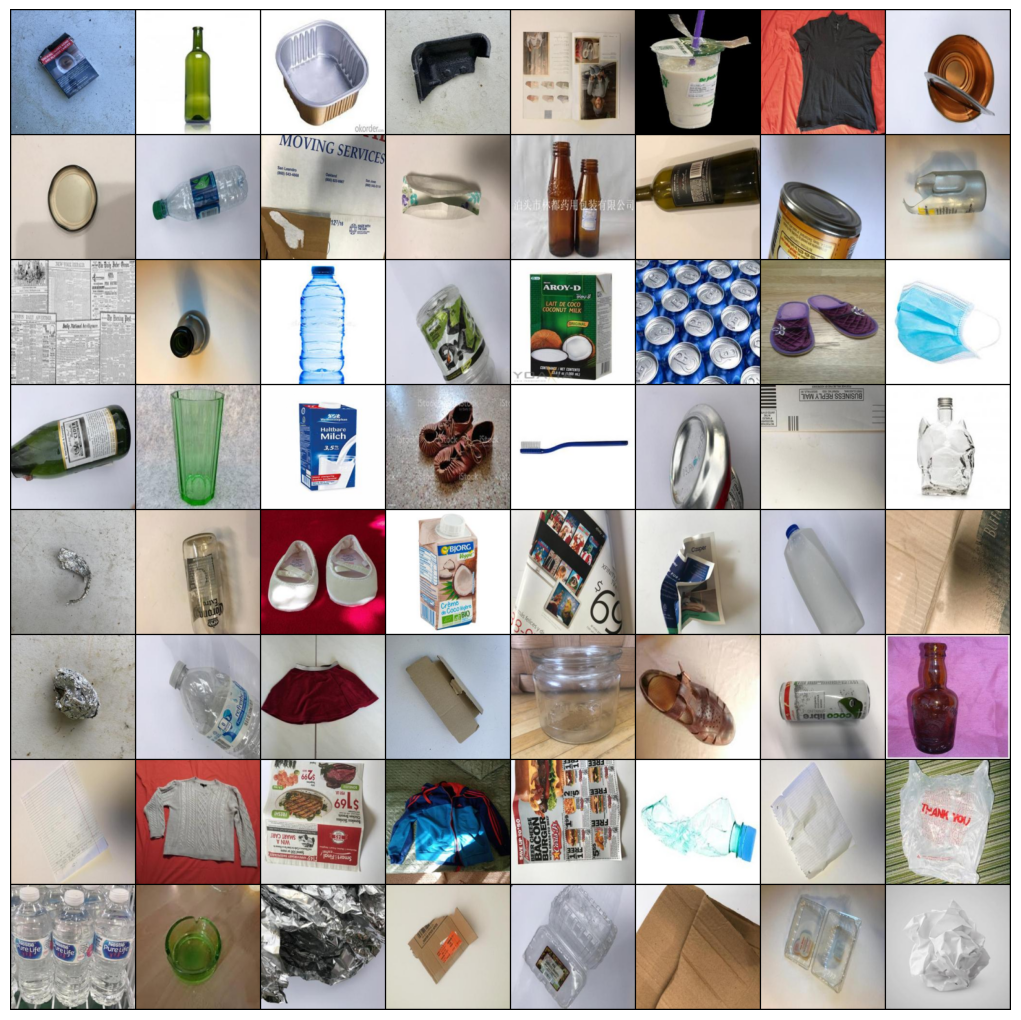

In [21]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=4, shuffle=False, pin_memory=True)

#可视化第一批64张图像8×8
def visualize(dataloader):

    images, labels = next(iter(dataloader))

    grid = make_grid(images, nrow=8)

    plt.figure(figsize=(13, 13))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

visualize(val_loader)


In [22]:
import torch
import torch.nn as nn

#图像数据选cnn做
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(CNN, self).__init__()
        
        #特征提取选relu函数激活
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        #自适应压缩
        self.gap = nn.AdaptiveAvgPool2d(1)
        #分类
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x


In [23]:
#实例化
model = CNN(num_classes=6, dropout_rate=0.15).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.00009)
loss = nn.CrossEntropyLoss()
#学习率以每四轮衰减15%
scheduler = StepLR(optimizer, step_size=4, gamma=0.85)

In [24]:
def train(train_loader):
  model.train()
  total_loss = total_samples = total_correct = 0
  y_true = []
  y_pred = []

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss1 = loss(outputs, labels)
    loss1.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    total_loss += loss1.item() * images.size(0)
    total_samples += images.size(0)
    y_true.append(labels.cpu().numpy())
    y_pred.append(outputs.argmax(dim=1).cpu().numpy())


    correct = (outputs.argmax(dim=1) == labels).sum().item()
    total_correct += correct

    accuracy = total_correct / total_samples * 100
  return total_loss / total_samples, accuracy

In [25]:
@torch.no_grad()
def val(val_loader):
    model.eval()
    total_loss = total_samples = total_correct = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss1 = loss(outputs, labels)

        total_loss += loss1.item() * images.size(0)
        total_samples += images.size(0)

        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    accuracy = total_correct / total_samples * 100
    return total_loss / total_samples, accuracy


In [26]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy_list = []

epochs = 100

for epoch in range(epochs):
    train_loss, train_acc = train(train_loader)
    scheduler.step()
    val_loss, val_acc = val(val_loader)

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy_list.append(val_acc)

    print(f"Epoch: {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")


Epoch: 1/100 | Train Loss: 1.5387, Train Accuracy: 43.00% | Val Loss: 1.4141, Val Accuracy: 48.77%
Epoch: 2/100 | Train Loss: 1.3810, Train Accuracy: 49.54% | Val Loss: 1.3255, Val Accuracy: 52.19%
Epoch: 3/100 | Train Loss: 1.3194, Train Accuracy: 51.59% | Val Loss: 1.2940, Val Accuracy: 53.63%
Epoch: 4/100 | Train Loss: 1.2658, Train Accuracy: 53.82% | Val Loss: 1.3411, Val Accuracy: 50.13%
Epoch: 5/100 | Train Loss: 1.2297, Train Accuracy: 54.87% | Val Loss: 1.2230, Val Accuracy: 55.96%
Epoch: 6/100 | Train Loss: 1.1973, Train Accuracy: 56.51% | Val Loss: 1.2189, Val Accuracy: 55.91%
Epoch: 7/100 | Train Loss: 1.1676, Train Accuracy: 57.55% | Val Loss: 1.1586, Val Accuracy: 58.45%
Epoch: 8/100 | Train Loss: 1.1502, Train Accuracy: 59.15% | Val Loss: 1.1691, Val Accuracy: 58.57%
Epoch: 9/100 | Train Loss: 1.1242, Train Accuracy: 59.40% | Val Loss: 1.1640, Val Accuracy: 58.45%
Epoch: 10/100 | Train Loss: 1.1033, Train Accuracy: 60.38% | Val Loss: 1.0975, Val Accuracy: 61.26%
Epoch: 11

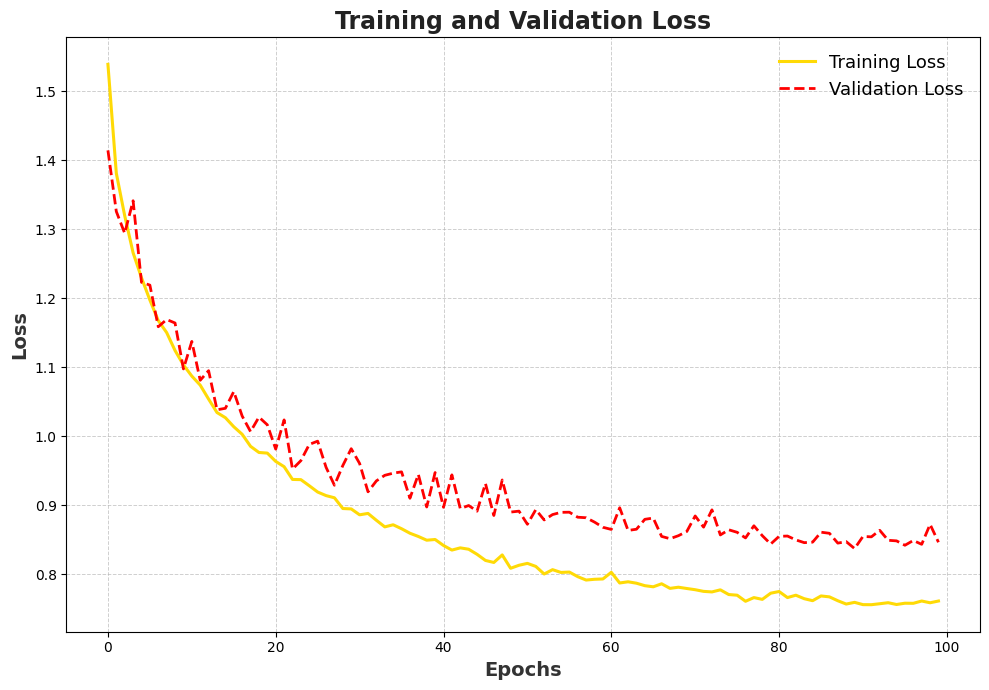

In [27]:
#画loss曲线
plt.style.use("default")

plt.figure(figsize=(10, 7))

plt.plot(range(epochs), training_loss, label='Training Loss',
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), validation_loss, label='Validation Loss',
         color='red', linestyle='--', linewidth=2, alpha=1)

plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('Loss', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

plt.legend(loc='upper right', fontsize=13, frameon=False)

plt.tight_layout()
plt.show()

In [28]:
@torch.no_grad()
def eval(loader):
    model.eval()
    preds, trues = [], []

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        preds.append(probs.cpu())
        trues.append(labels.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    predicted_classes = preds.argmax(axis=1)

    df_result = pd.DataFrame({
        'actual': trues,
        'probability': list(preds),
        'pred': predicted_classes
    })
    return df_result

In [30]:
val_res = eval(val_loader)
class_names = full_dataset.classes
print(classification_report(val_res['actual'], val_res['pred'], target_names=class_names))
#给报告

              precision    recall  f1-score   support

   cardboard       0.77      0.76      0.77       631
       glass       0.67      0.70      0.69       752
       metal       0.71      0.80      0.75       655
       paper       0.76      0.70      0.72       705
     plastic       0.67      0.59      0.63       680
       trash       0.67      0.70      0.68       748

    accuracy                           0.71      4171
   macro avg       0.71      0.71      0.71      4171
weighted avg       0.71      0.71      0.71      4171



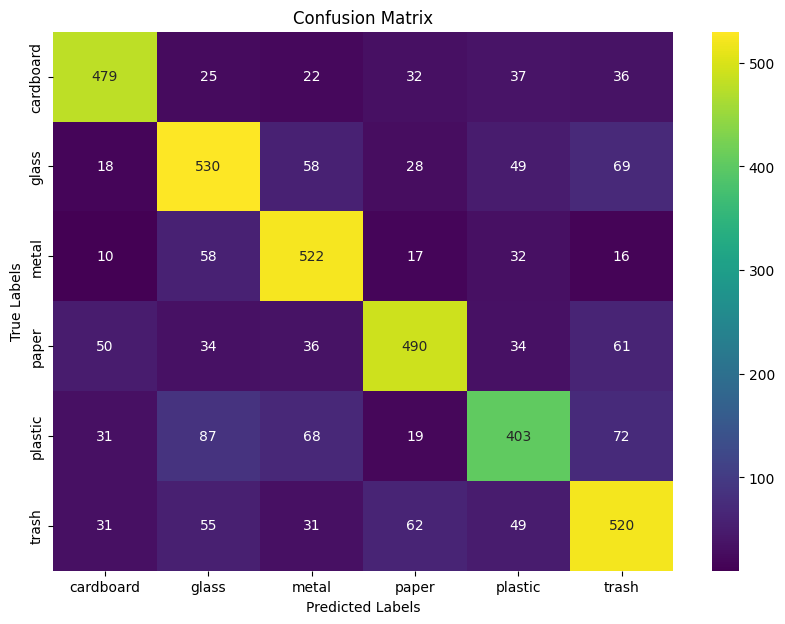

In [31]:
#混淆矩阵
ConfusionMatrix = confusion_matrix(val_res['actual'], val_res['pred'])

plt.figure(figsize=(10, 7))

sns.heatmap(ConfusionMatrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

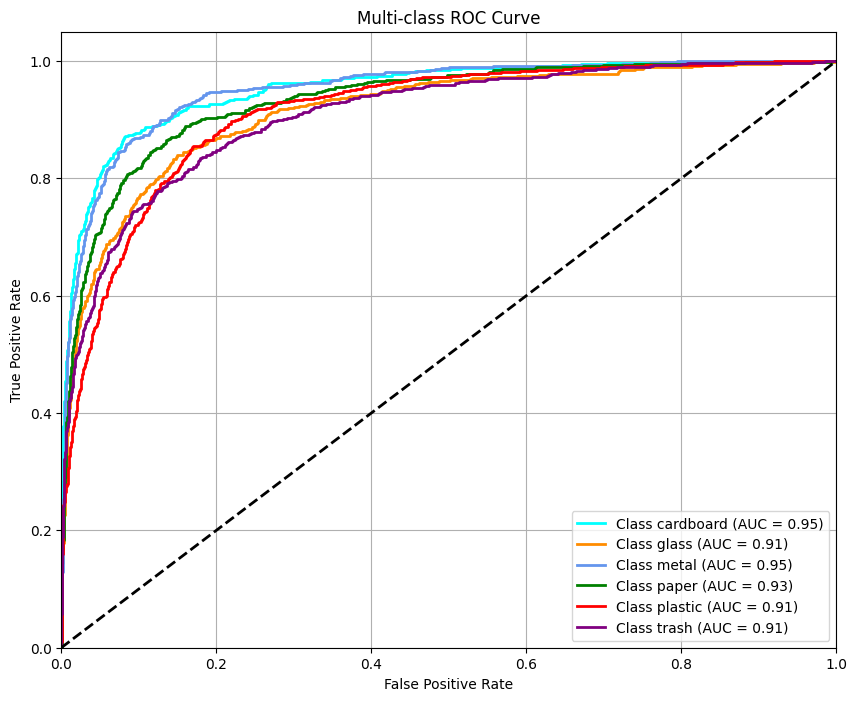

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

val_res = eval(val_loader)  
class_names = full_dataset.classes
n_classes = len(class_names)

y_true = val_res['actual'].values  
y_score = np.vstack(val_res['probability'].values)  

#独热编码
y_true_bin = label_binarize(y_true, classes=range(n_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


#我们有六类，，画六类的ROC

plt.figure(figsize=(10,8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
#auc上限为1，越接近1越好
#之所以想看auc是因为Val_loss曲线有点抖不太放心